In [1]:
from classes import Team

from itertools import product

import pandas as pd
import numpy as np
from scipy.special import factorial
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl

In [2]:
names = {
    "FCB": "Bayern München",
    "B04": "B. Leverkusen",
    "SGE": "E. Frankfurt",
    "BVB": "Bor. Dortmund",
    "SCF": "SC Freiburg",
    "M05": "1.FSV Mainz 05",
    "RBL": "RB Leipzig",
    "SVW": "Werder Bremen",
    "VFB": "VfB Stuttgart",
    "BMG": "Bor. M'gladbach",
    "WOB": "VfL Wolfsburg",
    "FCA": "FC Augsburg",
    "FCU": "Union Berlin",
    "STP": "FC St. Pauli",
    "TSG": "TSG Hoffenheim",
    "HDH": "1.FC Heidenheim",
    "KOE": "1.FC Köln",
    "HSV": "Hamburger SV",
    "BSC": "Hertha BSC"
}

In [3]:
home_team = names["RBL"]
away_team = names["WOB"]

In [4]:
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["figure.constrained_layout.use"] = True
mpl.rcParams["figure.frameon"] = False
mpl.rcParams["font.sans-serif"] = ["Lexend"] + mpl.rcParams["font.sans-serif"]
mpl.rcParams["legend.framealpha"] = 1.0

In [5]:
df = pd.read_csv("model.csv")
df.head(18)

,name,home_attack,home_defense,away_attack,away_defense
0,Bayern München,43.636108,15.223394,32.710606,18.097633
1,Bor. Dortmund,32.693217,11.654489,20.393199,14.843872
2,B. Leverkusen,27.694872,11.441294,22.771095,17.229217
3,RB Leipzig,28.269299,11.503635,16.171159,15.292123
4,VfB Stuttgart,24.323528,8.535515,19.506528,12.711539
5,E. Frankfurt,25.669876,7.468346,17.646135,7.640300
6,TSG Hoffenheim,25.079647,3.000050,17.587973,11.080014
7,1.FSV Mainz 05,17.728186,11.686072,13.458423,10.855163
8,SC Freiburg,23.203887,7.335048,9.550420,10.682865
9,Bor. M'gladbach,20.391948,4.885967,14.134025,9.162005


In [6]:
teams = {}
for index, row in df.iterrows():
    name = row["name"]
    home_att = row["home_attack"]
    home_dfe = row["home_defense"]
    away_att = row["away_attack"]
    away_dfe = row["away_defense"]

    teams[name] = Team(name, home_att, home_dfe, away_att, away_dfe)

In [7]:
prediction = teams[home_team].match(teams[away_team])

print(*prediction)

2.0988729260221253 1.068813764480014


In [8]:
def poisson(k, l):
    return l**k / factorial(k, exact=True) * np.exp(-l)

In [9]:
p = teams[home_team].calculate_win_probabilities(teams[away_team])

print(*[f"{100*r:.3}%" for r in p])

61.0% 20.5% 18.5%


In [10]:
results = []
for h, a in product(range(0, 6), repeat=2):
    results.append((h, a, poisson(h, prediction[0])*poisson(a, prediction[1])))

In [11]:
results.sort(key=lambda x: x[-1], reverse=True)

In [12]:
print(*[f"{r[0]}:{r[1]}  {100*r[2]:.3}%" for r in results[:10]], sep="\n")

2:1  9.91%
1:1  9.44%
2:0  9.27%
1:0  8.84%
3:1  6.93%
3:0  6.49%
2:2  5.3%
1:2  5.05%
0:1  4.5%
0:0  4.21%


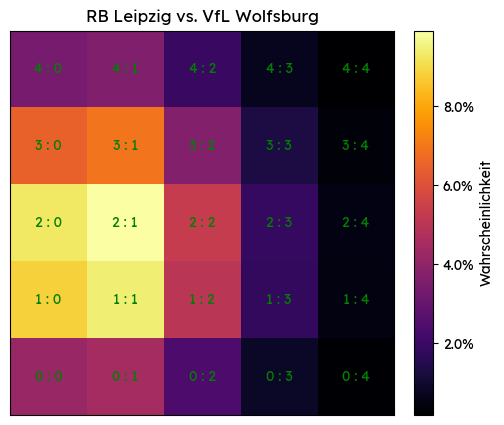

In [13]:
teams[home_team].show_probability_distribution(teams[away_team], save=True)

In [14]:
N = 5
M = 6

draw_factor = 1.172 + sum(prediction)/12.7839
draw_factor = 1.172
print(draw_factor)

results = np.zeros((M, M))

for i in range(M):
    for j in range(M):
        results[i, j] = poisson(i, prediction[0])*poisson(j, prediction[1])

points = np.zeros((N, N))
point_list = []

for i in range(N):
    for j in range(N):
        poi = np.zeros((M, M))
        for a in range(M):
            for b in range(M):
                if i == a and j == b:
                    poi[a, b] = 4
                elif (i-j) == (a-b):
                    poi[a, b] = 3
                elif i > j and a > b:
                    poi[a, b] = 2
                elif i < j and a < b:
                    poi[a, b] = 2

                if a == b:
                    poi[a, b] *= draw_factor

        points[i, j] = np.sum(results * poi)
        point_list.append((i, j, np.sum(results * poi)))

1.172


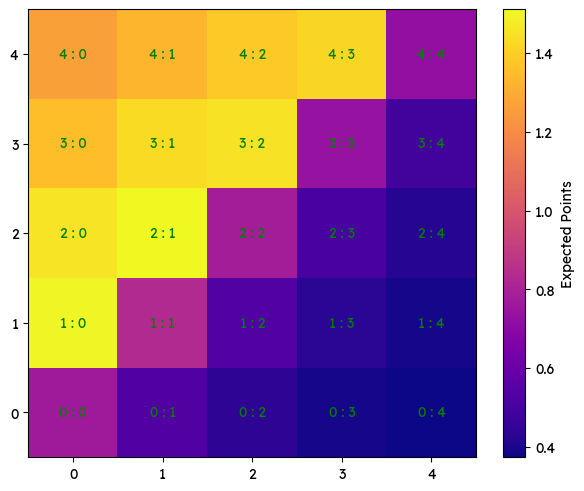

In [15]:
heatmap = plt.imshow(points, cmap='plasma', origin="lower")
cb = plt.colorbar(heatmap, label='Expected Points')

font_props = {"ha": "center",
              "va": "center",
              "color": "g"}

for i in range(N):
    for j in range(N):
        plt.text(j, i, f'{i} : {j}', **font_props)

plt.show()

In [16]:
point_list.sort(key=lambda x: x[-1], reverse=True)

print(*[f"{p[0]}:{p[1]}  {p[2]:.4}" for p in point_list[:10]], sep="\n")

2:1  1.511
1:0  1.5
2:0  1.457
3:2  1.449
3:1  1.433
4:3  1.419
4:2  1.383
3:0  1.354
4:1  1.325
4:0  1.263
